Creación de un pipeline de entrada con tf.data --- 0:00 min
===

* Última modificación: Marzo 1, 2022 | YouTube

## Importación de librerías

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Descarga de archivos de ejemplo de TensorFlow
---

In [2]:
import pathlib

#
# Esta celda es idéntica a la lección anterior
#
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    # -----------------------------------------------------------------------------------
    # Ubicacion donde seran guardados los archivos
    fname="flower_photos",
    # -----------------------------------------------------------------------------------
    # Direccion web de los archivos
    origin=dataset_url,
    # -----------------------------------------------------------------------------------
    # Extracción de archivos tar, zip, ...
    untar=True,
    # -----------------------------------------------------------------------------------
    # Directorio para almacenamiento de los datos
    cache_subdir="/tmp/",
)
data_dir = pathlib.Path(data_dir)

Pipeline de entrada
---

In [3]:
image_count = len(list(data_dir.glob("*/*.jpg")))

list_ds = tf.data.Dataset.list_files(
    str(data_dir / "*/*"),
    shuffle=False,
)

list_ds = list_ds.shuffle(
    image_count,
    reshuffle_each_iteration=False,
)

Particionamiento de los datos
---

In [4]:
#
# Tamaño del conjunto de validación.
#
val_size = int(image_count * 0.2)

#
# Conjunto de entrenamiento. Se ignoran los primeros val_size elementos del datasest.
#
train_ds = list_ds.skip(val_size)

#
# Conjunto de validación. Se toman los primeros val_size elementos del dataset.
#
val_ds = list_ds.take(val_size)

#
# Tamaño:
#
display(
    tf.data.experimental.cardinality(train_ds).numpy(),
    tf.data.experimental.cardinality(val_ds).numpy(),
)

2936

734

Obtención de las clases
---

In [5]:
import numpy as np

class_names = np.array(
    sorted([item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"])
)
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Creación de pares (X, y)
---

In [6]:
import os


def get_label(file_path):
    #
    # Extrae las partes del path.
    #   /tmp/flowers_photos/tulips/100930342_92e8746431_n.jpg
    #   ['tmp', 'flowers_photos', 'tulips', '100930342_92e8746431_n.jpg']
    #
    parts = tf.strings.split(file_path, os.path.sep)

    # La segunda parte de la cadena es el nombre y la compara contra los nombres
    # de las clases. Retorna un vector True/False de cinco posiciones
    one_hot = parts[-2] == class_names

    #
    # Codificación del nombre como entero en {0, 1, 2, 3, 4}
    #
    return tf.argmax(one_hot)


def decode_img(img):
    #
    # Convierte la imagen en un vector de tres posiciones RGB
    #
    img = tf.io.decode_jpeg(img, channels=3)

    #
    # Cambia el tamaño de la imagen a las dimensiones deseadas
    #
    img_height = 180
    img_width = 180

    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    #
    # Obtiene un entero que codifica la clase de la imágen.
    label = get_label(file_path)

    #
    # Carga la imagen como un string desde el disco y la decodifica.
    #
    img = tf.io.read_file(file_path)
    img = decode_img(img)

    #
    # Retorna la tupla (imagen, label)
    #
    return img, label


#
# Procesamiento de los archivos. Se paraleliza con AUTOTUNE
#
train_ds = train_ds.map(
    process_path,
    num_parallel_calls=tf.data.AUTOTUNE,
)

val_ds = val_ds.map(
    process_path,
    num_parallel_calls=tf.data.AUTOTUNE,
)

Configuración del conjunto de datos para desempeño
----

In [7]:
def configure_for_performance(ds):
    #
    # En la primera lectura, los datos pasan al cache; en las siguientes
    # lecturas los datos son leidos del cache
    #
    ds = ds.cache()

    #
    # Se seleccionan 1000 elementos del dataset. Luego, cuando un elemento es
    # seleccionado, es reemplazado por un elemento del segundo bloque de 1000
    # elementos, y así sucesivamente.
    #
    ds = ds.shuffle(buffer_size=1000)

    #
    # Combina elementos consecutivos del dataset en un lote del tamaño
    # especificado
    #
    ds = ds.batch(batch_size=32)

    #
    # Prepara el siguiente lote de elementos mientras el bloque actual esta
    # siendo procesado.
    #
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds = configure_for_performance(train_ds)

val_ds = configure_for_performance(val_ds)

Visualización de datos
---

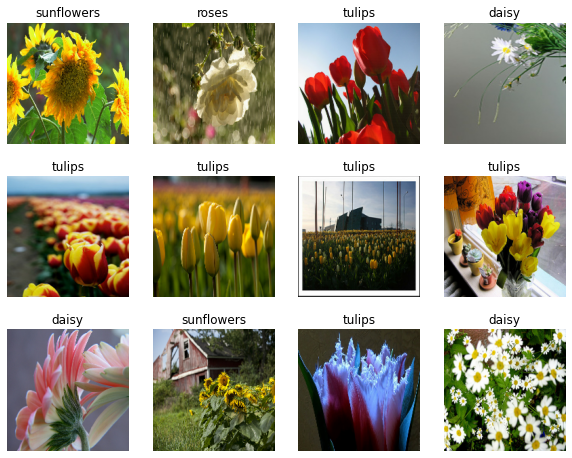

In [8]:
#
# Este código es identico al de la lección anterior
#
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Creación y entrenamiento del modelo
---

In [9]:
#
# >>> Este código es identico al ejemplo anterior >>>>
#
num_classes = 5

model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255),
        #
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        #
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        #
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        #
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

In [10]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
)

Epoch 1/3
92/92 [==============================] - 35s 368ms/step - loss: 1.3204 - accuracy: 0.4285 - val_loss: 1.1147 - val_accuracy: 0.5272
Epoch 2/3
92/92 [==============================] - 34s 368ms/step - loss: 1.0267 - accuracy: 0.5845 - val_loss: 1.0206 - val_accuracy: 0.5899
Epoch 3/3
92/92 [==============================] - 37s 405ms/step - loss: 0.8856 - accuracy: 0.6720 - val_loss: 1.0050 - val_accuracy: 0.5995


**Nota.** El objetivo de esta lección es ejemplificar la carga de imágenes desde un directorio, por lo que no se analizará el modelo.